In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import json
import torchvision.datasets as dsets
import torch.utils.data as Data

In [2]:
# Method : we use 

epsilons = [0, .05, .1, .15, .2, .25, .3]
torch.manual_seed(18)

In [3]:
indexes = json.load(open("data/imagenet_class_index.json"))
indx_2labels = [indexes[str(k)][1] for k in range(len(indexes))]

In [4]:
device = torch.device("cpu")

In [5]:
# We want to transform the image to a tensor and normalize it

preprocess = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.ToTensor(),
])

In [6]:

train_data = dsets.ImageFolder(root='./data', transform=preprocess)
train_classes = train_data.classes

labels = {}

for i, j in enumerate(indx_2labels):
    labels[j] = i

data = dsets.ImageFolder(root='./data', transform=preprocess, target_transform= lambda x: indx_2labels.index(train_classes[x]))
data.classes = indx_2labels
data.class_to_idx = labels

loader = Data.DataLoader(data, batch_size=1, shuffle=False)

In [7]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
model.eval()

Using cache found in /Users/quentinrolland/.cache/torch/hub/pytorch_vision_v0.10.0
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [8]:

# Here is the function that will compute the adversarial examples

def adv_attack(model, image, epsilon, loss, labels):

    # Move the model to the CPU
    image = image.to(device) # Move to CPU
    labels = labels.to(device) 
    image.requires_grad = True
    sorties = model(image)

    model.zero_grad() # zero all the gradients
    cost = loss(sorties, labels).to(device) # compute the loss
    cost.backward() # compute the gradient of the loss

    # compute the sign of gradient
    sign_data_grad = image.grad.sign()
    # generate the altered image
    altered_image = image + epsilon*sign_data_grad

    # clipping to maintain [0,1] range
    altered_image = torch.clamp(altered_image, 0, 1)

    return altered_image

In [9]:
loss = nn.CrossEntropyLoss()

In [11]:
def test( model, device, normal_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for image, labels in normal_loader:

        image, labels = image.to(device), labels.to(device)
        output = model(image)
        init_pred = output.max(1, keepdim=True)[1]

        # Call FGSM Attack
        altered_data = adv_attack(model, image, epsilon, loss, labels).to(device)

        # Re-classify the perturbed image
        output = model(altered_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == labels.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = altered_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = altered_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        
        probabilities = nn.functional.softmax(output, dim=1)
        confidence, predictions = torch.max(probabilities, dim=1)

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(normal_loader))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(normal_loader)} = {final_acc}")

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples, confidence

In [20]:
model.eval()

accuracies = [] # not really relevant given we only test on one image
confidences = []
examples = []
correct = 0
total = 0

for eps in epsilons:
    acc, ex, conf = test(model, device, loader, eps)
    #accuracies.append(acc)
    examples.append(ex)
    confidences.append(1 - conf.item())

print(confidences)

Epsilon: 0	Test Accuracy = 1 / 1 = 1.0
Epsilon: 0.05	Test Accuracy = 0 / 1 = 0.0
Epsilon: 0.1	Test Accuracy = 0 / 1 = 0.0
Epsilon: 0.15	Test Accuracy = 0 / 1 = 0.0
Epsilon: 0.2	Test Accuracy = 0 / 1 = 0.0
Epsilon: 0.25	Test Accuracy = 0 / 1 = 0.0
Epsilon: 0.3	Test Accuracy = 0 / 1 = 0.0
[0.9170568957924843, 0.9322726652026176, 0.9372603222727776, 0.9757282678037882, 0.9484069645404816, 0.9459425732493401, 0.9484201036393642]


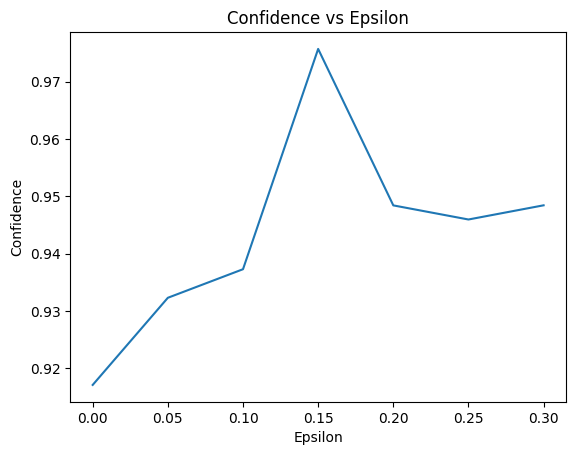

In [21]:
import matplotlib.pyplot as plt

# Plot the confidence values
plt.plot(epsilons, confidences)
plt.xlabel('Epsilon')
plt.ylabel('Confidence')
plt.title('Confidence vs Epsilon')
plt.show()
